# All to all network Simulations

We simulate the whole network as an array and we reset it to the initial configuration following a Poisson process

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from IPython.display import clear_output
import imageio.v2 as imageio
from tqdm import tqdm

import sys
from importlib import reload
sys.path.append("../scripts")
import solution as sol

sol = reload(sol)

In [14]:
@njit
def init_config(N, m0):
    fra1 = (1+m0)/2
    r = np.ones(N)   # array of 0 or 1
    r[round(fra1*N)-1:-1] = -1
    return r 

@njit
def voter_model_evolution(N, t, r, m0):
    '''Takes:
    N: number of agents
    t: time in MC steps
    r: resetting rate per MC step
    m0: starting magnetisation
    
        Returns:
    config: The config at time t
    res: number of resets'''

    config = init_config(N, m0)
    ini = config.copy()

    res = 0

    for _ in range(t):
        for _ in range(N):
            
            if np.random.rand() < r/N: #Try to reset
                config = ini.copy()
                res = res +1
                continue
            
            a = np.random.randint(N)
            b = np.random.randint(N-1)
            if b >= a:
                b += 1
            
            config[a] = config[b] #If no reset occurs, apply normal VM dynamics

    return(config, res)

## Check Poisson

In [3]:
@njit
def check_poisson(N, T, r, div, samples):
    '''Checks if the resetting is a poisson process.
    Takes the same arguments as the simulation plus:
    
    div: number of different times we sample
    samples: number of samples per time
    '''
    
    res = np.zeros(div)

    ts = np.linspace(0, T, div)

    for i in range(div):
        t = ts[i]

        total = 0.0
        for _ in range(samples):
            _, resets = voter_model_evolution(N, int(t), r) #Calculate resets up to time t
            total += resets

        res[i] = total / samples

    return res

Text(0, 0.5, 'Resets')

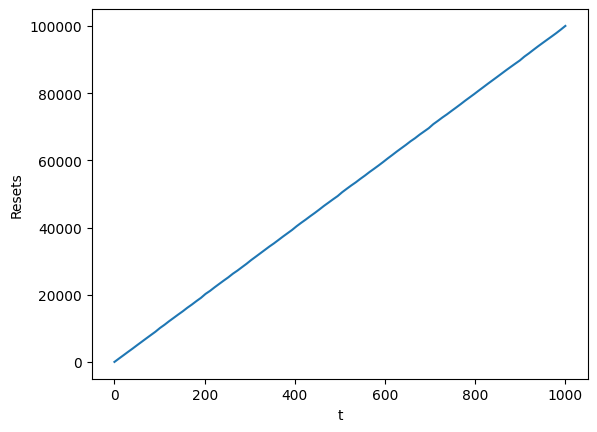

In [4]:
plt.plot(np.linspace(0, 1000, 100), check_poisson(1000, 1000, 0.1, 100, 50))
plt.xlabel("t")
plt.ylabel("Resets")

## Distribution of Magnetisation

In [4]:
@njit
def mag(config):
    '''Returns the magnetisation given the state configuration'''
    return(np.mean(config))

@njit
def dist(N, t, r, m0, samples):
    '''Returns the magnetisation at time t for some samples'''
    res = np.zeros(samples)

    for i in range(samples):
        res[i] = mag(voter_model_evolution(N, t, r, m0)[0])
    
    return res

(array([  76.,   17.,   18.,   13.,   30.,   27.,   30.,   30.,   38.,
          37.,   40.,   58.,   68.,   68.,   60.,   56.,   90.,   88.,
         111.,  158.,  123.,  154.,  210.,  213.,  248.,  279.,  288.,
         330.,  398.,  470.,  517.,  644.,  698.,  881., 1015., 1086.,
        1368., 1656., 2021., 2550., 3169., 3588., 3501., 3070., 2853.,
        2539., 2250., 1960., 1854., 8954.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

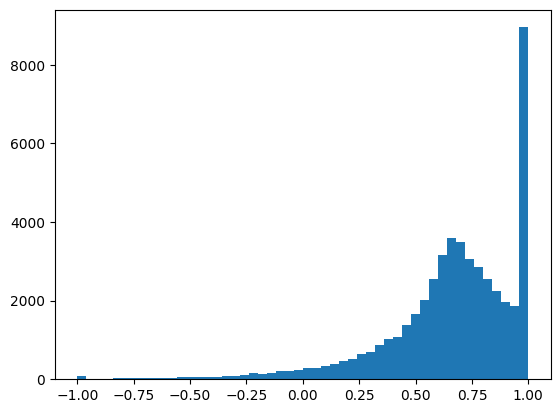

In [68]:
plt.hist(dist(1000, 1000, 0.01, 0.66, 50000), bins = 50)

# Compare 

In [69]:
d = dist(1000, 5000, 0.01, 0.5, 10000)

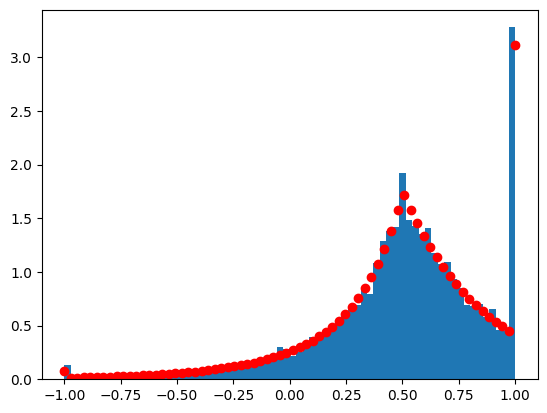

In [72]:
bins = 70
a = plt.hist(d, bins = bins, density=True)
plt.scatter(np.linspace(-1,1,bins), sol.sol(1000,0.01,0.5,bins), color = "r")

## Multicheck

m0: 0.9 r: 1 N: 1000


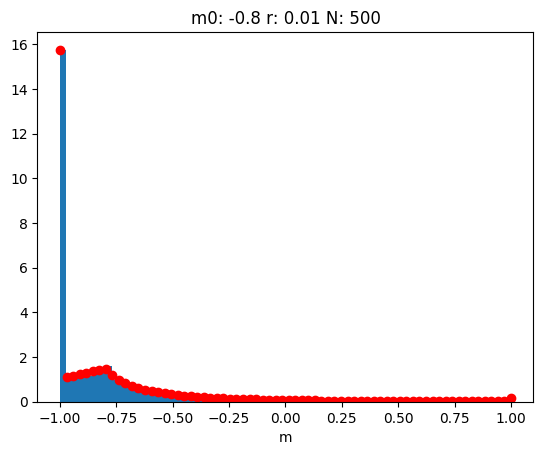

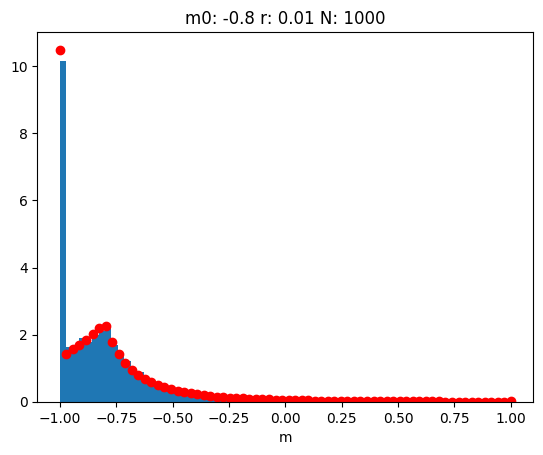

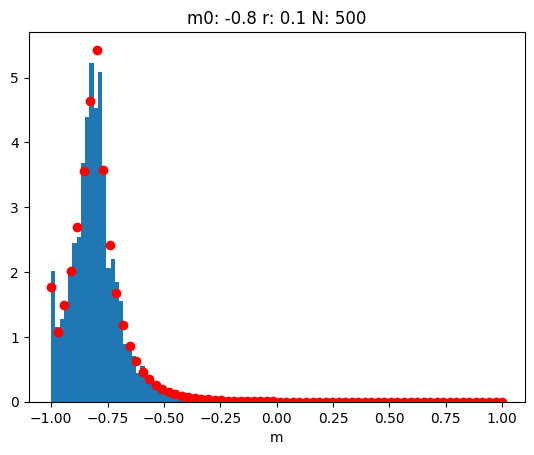

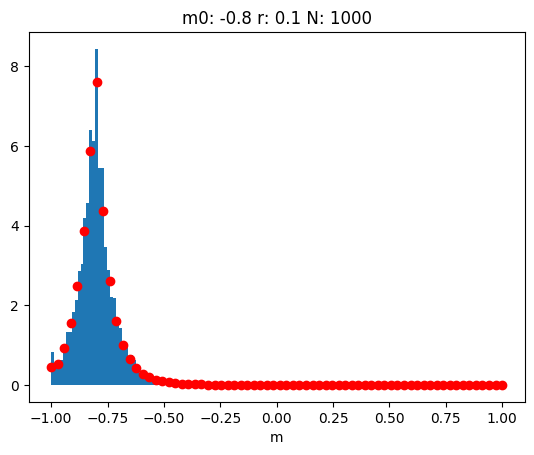

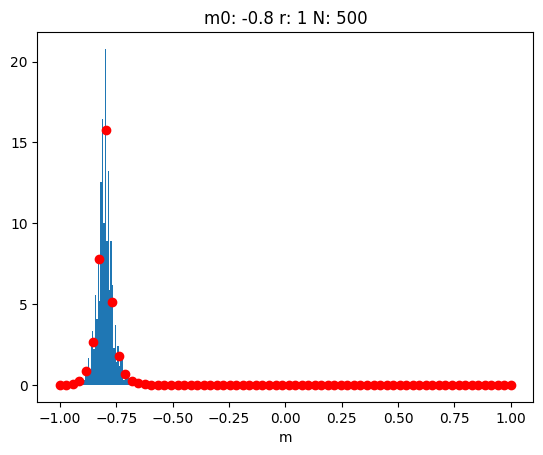

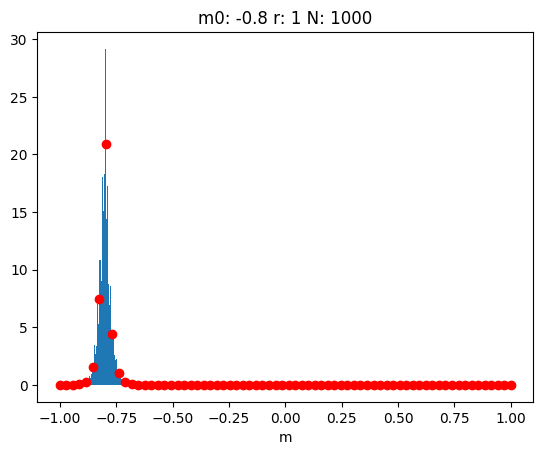

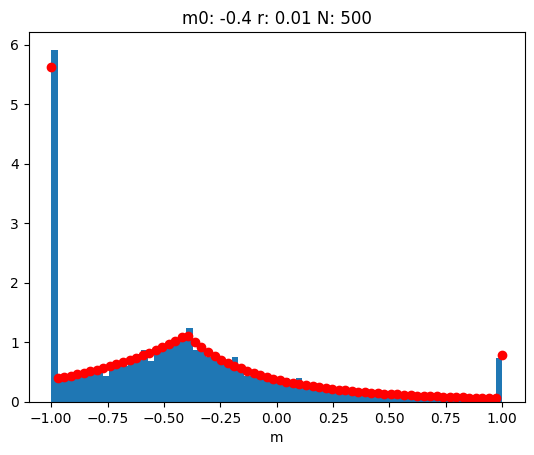

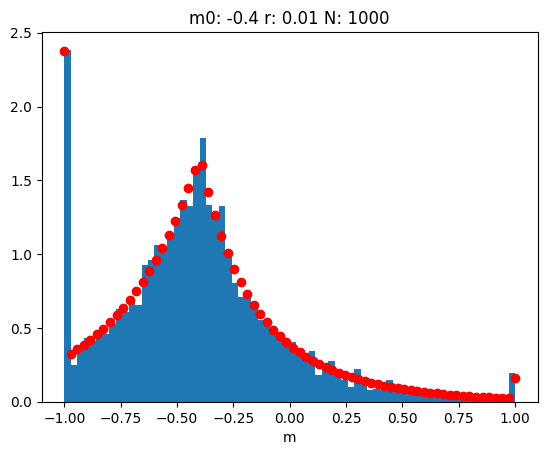

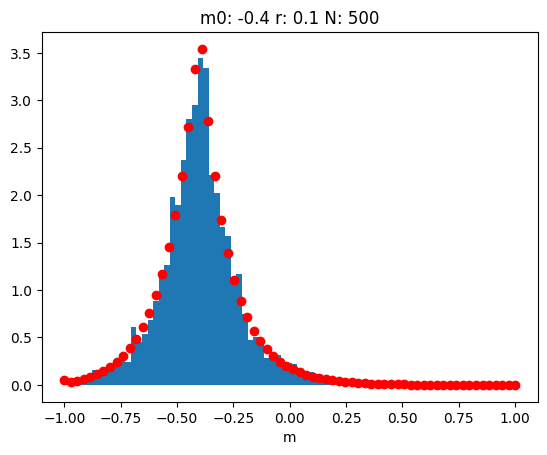

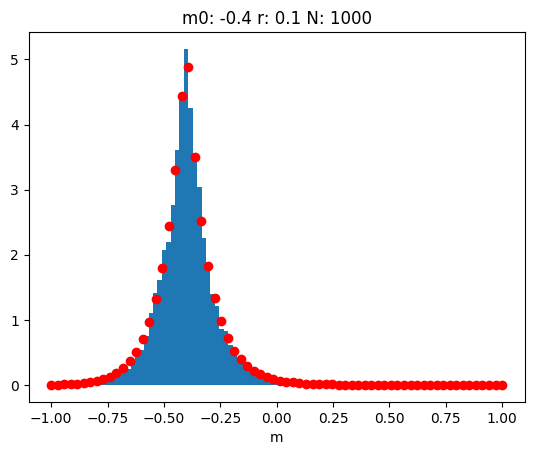

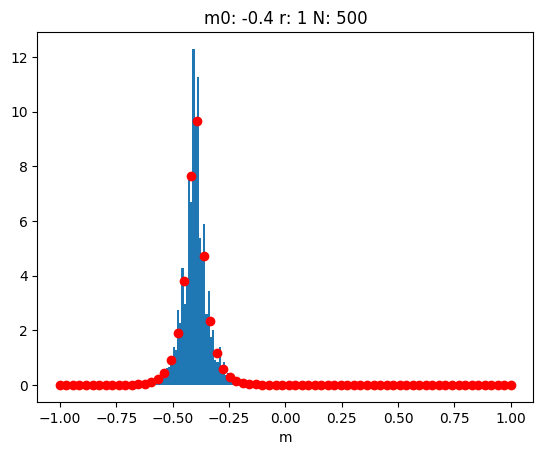

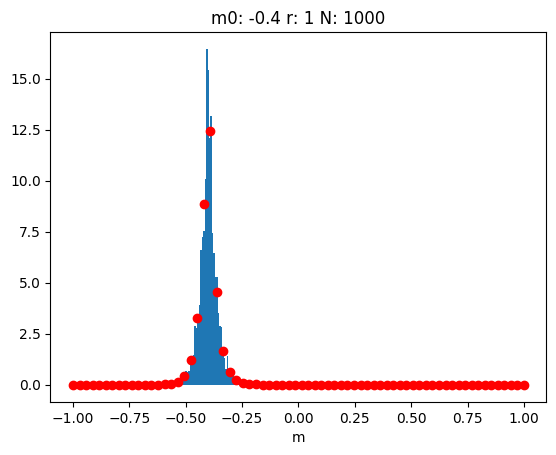

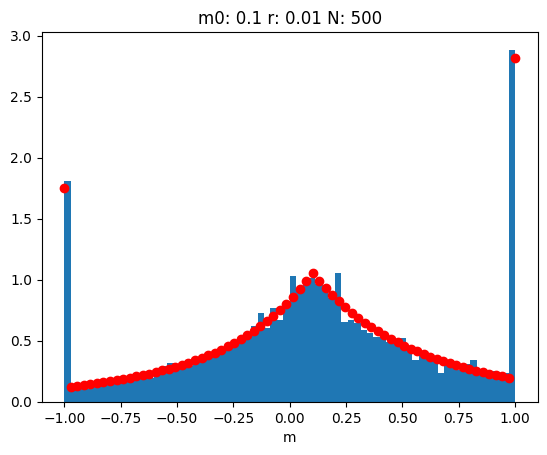

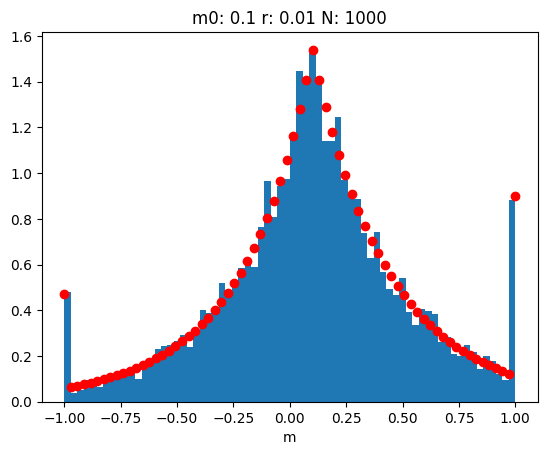

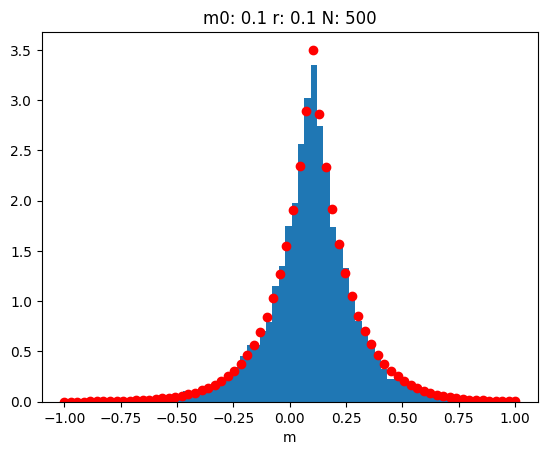

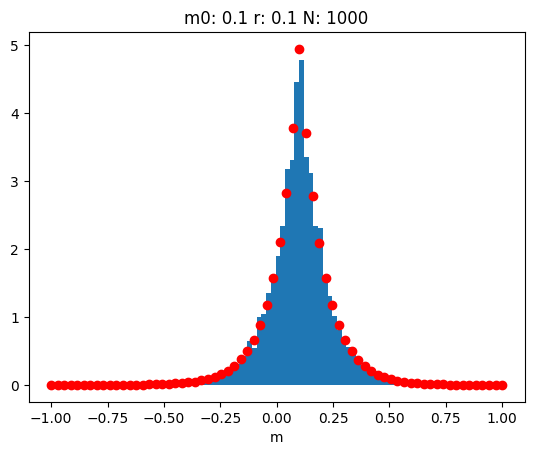

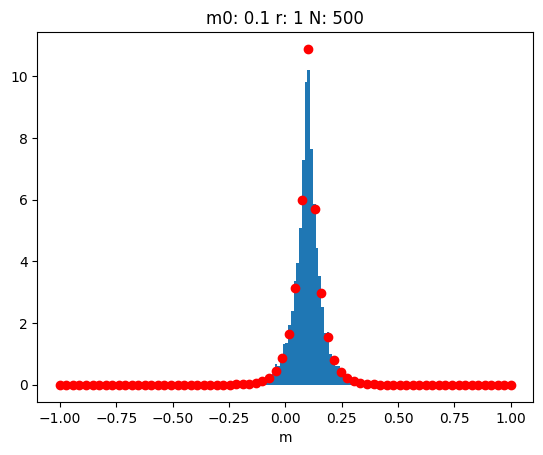

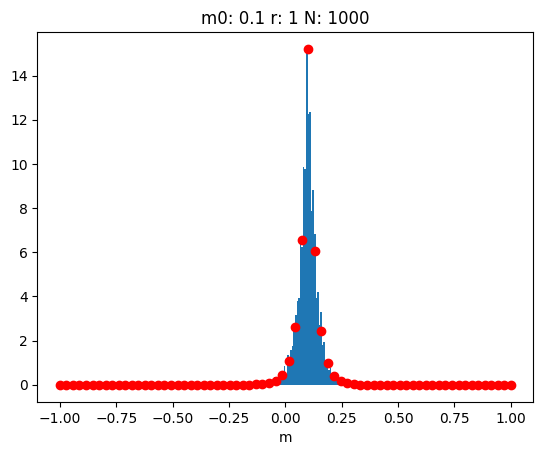

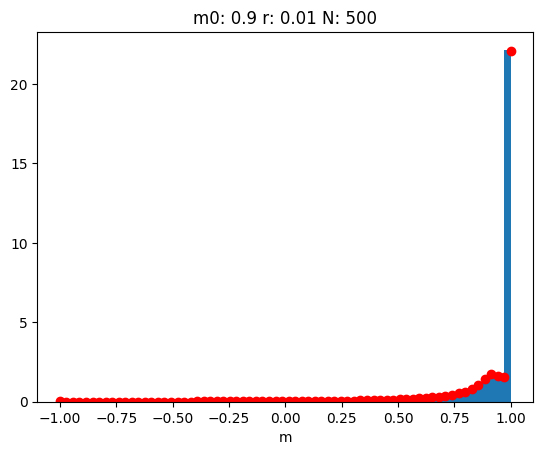

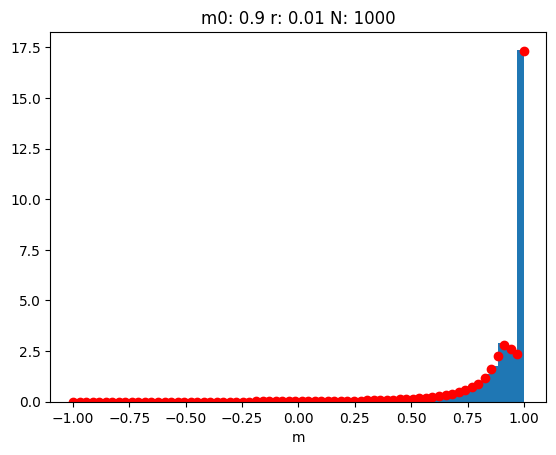

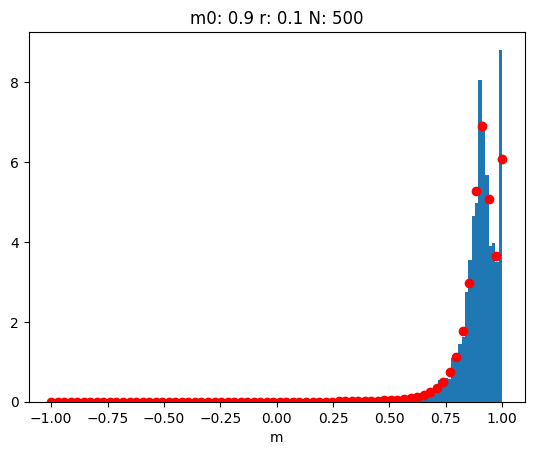

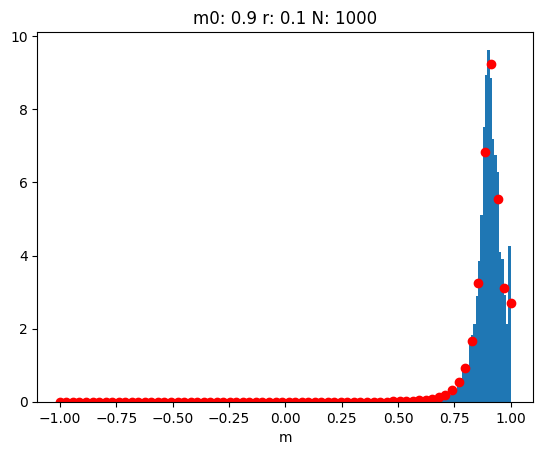

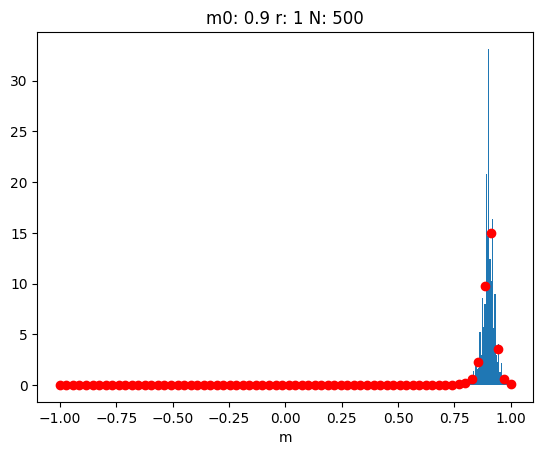

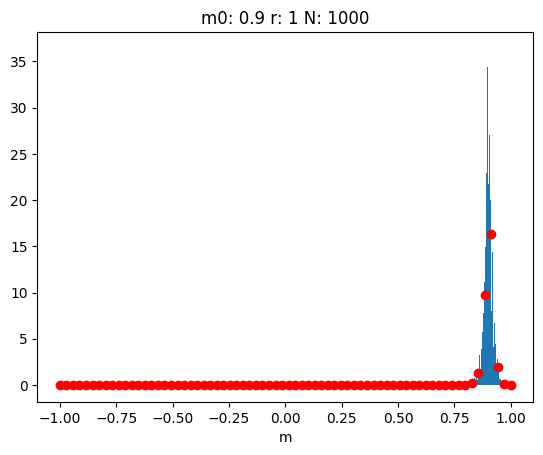

In [6]:
bins = 70
for m0 in [-0.8,-0.4,0.1,0.9]:
    for r in [0.01,0.1,1]:
        for N in [500, 1000]:
            clear_output(wait=True)
            print(f"m0: {m0} r: {r} N: {N}")
            plt.figure()
            plt.title(f"m0: {m0} r: {r} N: {N}")
            plt.xlabel("m")
            plt.hist(dist(N, 5*N, r, m0, 7500), bins = bins, density=True)        
            plt.scatter(np.linspace(-1,1,bins), sol.sol(N,r,m0,bins), color = "r")
            plt.savefig(f"../multi_check/figures/m0_{m0}_r_{r}_N_{N}.pdf")

# Time Evolution GIF

In [21]:
@njit
def voter_model_evolution_gif(N, t, r, m0, every):
    '''Takes:
    N: number of agents
    t: time in MC steps
    r: resetting rate per MC step
    every: time interval between frames
    
        Returns:
    mags: List of magnetisations at the different times '''

    config = init_config(N, m0)
    ini = config.copy()

    nframes = t // every + 1
    mags = np.zeros(nframes)

    mags[0] = mag(config)
    i = 1

    for ti in range(1, t + 1):
        for _ in range(N):
            if np.random.rand() < r:
                config = ini.copy()
                continue

            a = np.random.randint(0, N)
            b = np.random.randint(0, N)
            config[a] = config[b]

        if ti % every == 0:
            mags[i] = mag(config)
            i += 1

    return mags

@njit
def dist_gif(N, t, r, m0, samples, every):
    '''Returns the magnetisation at time t for some samples'''
    nframes = t // every + 1
    res = np.zeros((samples, nframes))

    for s in range(samples):
        res[s, :] = voter_model_evolution_gif(N, t, r, m0, every)

    return res

In [22]:
def make_compare_gif(
    filename,
    N,
    r,
    m0,
    samples,
    every,
    bins,
    t_max,
    ylim=None
):
    n_frames = int(t_max/every) + 1
    times = np.linspace(0, t_max, n_frames)
    # sim = dist_gif(N, t_max, r, m0, samples, every).T
    images = []

    for t in tqdm(times):
        p_th = sol.sol(N, r, m0, bins, t)
        p_sim = dist(N, t, r, m0, samples)

        fig, ax = plt.subplots(figsize=(6,4))
        ax.plot(np.linspace(-1,1,bins), p_th, lw=2)
        ax.hist(p_sim, bins = bins, density=True)
        ax.set_xlabel(r"$m$")
        ax.set_ylabel(r"$P(m,t)$")
        ax.set_title(rf"$t = {t:.2f}$")

        if ylim is not None:
            ax.set_ylim(*ylim)

        ax.grid(alpha=0.3)

        # Render to buffer
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        images.append(image)

        plt.close(fig)

    imageio.mimsave(filename, images, fps=12)

In [24]:
make_compare_gif("../figures/voter_reset_theory_vs_sim.gif", 1000, 0.01, 0, 5000, 1, 71, 1000, ylim = (0,5))

C:\Users\gerar\AppData\Local\Temp\ipykernel_32364\1938237222.py:35: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
 17%|█████████████▏                                                               | 172/1001 [45:00<3:36:56, 15.70s/it]


KeyboardInterrupt: 